# Data

Source: http://ai.stanford.edu/~amaas/data/sentiment/index.html \\
Description: \\
The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a score >= 7 out of 10. Thus reviews with
more neutral ratings are not included in the train/test sets. In the
unsupervised set, reviews of any rating are included and there are an
even number of reviews > 5 and <= 5.


In [0]:
from google.colab import files
import os
import re
import numpy as np
from keras import layers as L
from keras.models import Sequential
from sklearn.preprocessing import LabelBinarizer
from nltk.tokenize.casual import TweetTokenizer
#I used TweetTokenizer, because it includes some non-word tokens that may occur in reviews and may be sentiment markers (i. e., ':-)')
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
!git clone https://github.com/vyhuholl/imdb_review_classification.git

fatal: destination path 'imdb_review_classification' already exists and is not an empty directory.


In [0]:
uploaded = files.upload()

Saving embeddings.zip to embeddings (1).zip


#Preprocessing

In [0]:
PATH = 'imdb_review_classification/data/'

X_train = []
X_test = []
y_train = []
y_test = []
for file in os.listdir(PATH + 'train/pos'):
  rating = int(re.match('\d*_(\d*)', file).group(1))
  with open(PATH + 'train/pos/' + file) as text:
    review = text.read()
    X_train.append(review)
    y_train.append(rating)
for file in os.listdir(PATH + 'train/neg'):
  rating = int(re.match('\d*_(\d*)', file).group(1))
  with open(PATH + 'train/neg/' + file) as text:
    review = text.read()
    X_train.append(review)
    y_train.append(rating)
for file in os.listdir(PATH + 'test/pos'):
  rating = int(re.match('\d*_(\d*)', file).group(1))
  with open(PATH + 'test/pos/' + file) as text:
    review = text.read()
    X_test.append(review)
    y_test.append(rating)
for file in os.listdir(PATH + 'test/neg'):
  rating = int(re.match('\d*_(\d*)', file).group(1))
  with open(PATH + 'test/neg/' + file) as text:
    review = text.read()
    X_test.append(review)
    y_test.append(rating)

In [0]:
def text_to_sequence(text, vocab, vocab_size):
  seq = []
  for token in text:
    if token in vocab:
      seq.append(vocab[token])
    else:
      seq.append(vocab_size)
  return seq

#превращаем метки класса в one-hot векторы
encoder = LabelBinarizer()
encoder.fit([1, 2, 3, 4, 7, 8, 9, 10])
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
#токенизируем и векторизуем
tokenizer = TweetTokenizer()
training_corpus = ' '.join(map(str, X_train))
tokens = set(tokenizer.tokenize(training_corpus))
#для чистоты эксперимента обучать токенайзер будем только на обучающей выборке
vocab_size = len(tokens) + 1
vocab = {word: index for index, word in dict(enumerate(tokens, start=1)).items()}
#не удаляла стоп-слова, т. к., некоторые стоп-слова (например, отрицания) указывают на sentiment

#нейросеть, обученная на текстах, полученных с помощью texts_to_matrix(mode='tfidf'), давала очень низкую accuracy (около 0.2), поэтому я решила использовать text_to_sequences
X_train = [text_to_sequence(tokenizer.tokenize(text), vocab, vocab_size) for text in X_train]
X_test = [text_to_sequence(tokenizer.tokenize(text), vocab, vocab_size) for text in X_test]

In [0]:
# padding sequences to len 100
X_train = pad_sequences(X_train, maxlen=100, padding='post')
X_test = pad_sequences(X_test, maxlen=100, padding='post')

#Training simple neural network

In [0]:
model = Sequential()
model.add(L.Dense(512, input_shape=(100,)))
model.add(L.Activation('sigmoid'))
model.add(L.BatchNormalization())
model.add(L.Dense(256))
model.add(L.Activation('relu'))
model.add(L.BatchNormalization())
model.add(L.Dense(8))
model.add(L.Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               51712     
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 2056      
__________

In [0]:
score = model.evaluate(X_test, y_test,
                       batch_size=100, verbose=1)
print('Test accuracy:', score[1]) # низкая accuracy на test и validation, переобучилась :(

25000/25000 [==============================] - 1s 22us/step
Test accuracy: 0.16132000013440848


#Training neural network with GloVe embeddings

In [0]:
import zipfile
with zipfile.ZipFile("embeddings (1).zip","r") as zip_ref:
    zip_ref.extractall()

In [0]:
#loading the whole embedding in a memory as a dict

embeddings_index = dict()
with open('glove.6B.50d.txt') as file:
  for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

#creating a matrix for words from our reviews
embedding_matrix = np.zeros((vocab_size, 50))
for word, i in vocab.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [0]:
model = Sequential()
model.add(L.Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=100, trainable=False))
model.add(L.Flatten())
model.add(L.Dense(512))
model.add(L.Activation('sigmoid'))
model.add(L.Dropout(0.2))
model.add(L.Dense(256))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(8))
model.add(L.Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=1000,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           6149300   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               2560512   
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_16 (Activation)   (None, 256)               0         
__________

In [0]:
score = model.evaluate(X_test, y_test,
                       batch_size=100, verbose=1)
print('Test accuracy:', score[1]) #всё ещё мало, но уже лучше. Видимо, нужно было взять эмбеддинги большего объёма или большей размерности.

25000/25000 [==============================] - 1s 31us/step
Test accuracy: 0.24791999965906142


#Results

In [0]:
#посмотрим на результаты

y_test = encoder.inverse_transform(y_test)
y_pred = encoder.inverse_transform(y_pred)

print('True:', y_test[:10])
print('Predicted:', y_pred[:10]) #выбивается из ряда 10 с предсказанным значением 4

True: [ 9 10  9 10  9  8  9  8  9 10]
Predicted: [10  8  4 10  8  8  7 10  7 10]


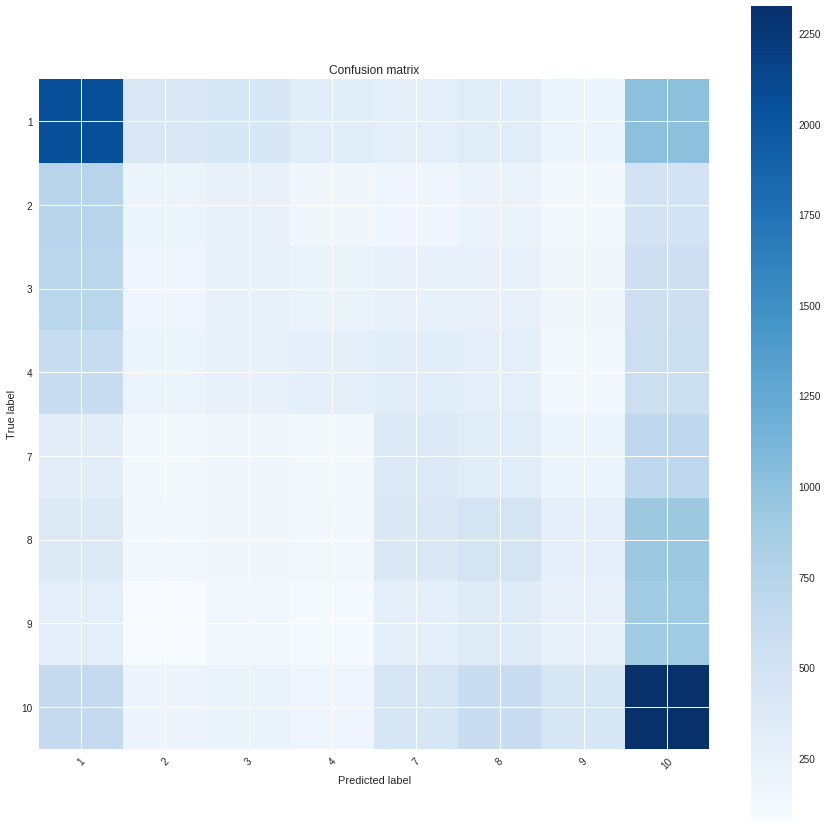

In [0]:
#построим матрицу ошибок

classes = [1, 2, 3, 4, 7, 8, 9, 10]

cm = metrics.confusion_matrix(y_test, y_pred)

plt.rcParams["figure.figsize"] = (15, 15)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(8)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [0]:
#попробуем классифицировать новый текст

new_text = """What a unique production! Netflix definitely got something (very) right here. In fact, I wish there would be more quality content like this.
Every single episode is intriguing and spectacular; it can be very violent at times, funny and sad. The art is just breathtaking. Writing is on point.
So far I liked "Sonnie's Edge", "The Witness" and "Beyond the Aquila Rift, "Good Hunting" and "Zima Blue" the best. More, please, Netflix!"""
#источник -- https://www.imdb.com/review/rw4723901 , рейтинг -- 10
x_new = pad_sequences([text_to_sequence(tokenizer.tokenize(new_text), vocab, vocab_size)], maxlen=100, padding='post')
cl_new = model.predict_classes(x_new)[0]
print(classes[cl_new])

9


In [0]:
new_text = """If nobody does, I will. After the critically panned Date Movie, Epic Movie, and Meet the Spartans, these two assholes decide to make another. It's the same formula, they make fun of popular movies in a tired, unfunny fashion.
I saw it with a few friends, hoping maybe I could get maybe one or two laughs out of it (I didn't expect anything). When I came out, I was seriously stunned at how lame the movie was. One friend actually liked it, all I had to say was, "What have you been smoking lately?".
I'm not even going to bother explaining the plot, since there really isn't a plot at all. All I can say is, don't waste your money watching the film. It contains no genuinely funny humor and is one of the worst movies ever made. And everyone thought Meet the Spartans bad, wait until they get a load of this one."""
#источник -- https://www.imdb.com/review/rw1938122 , рейтинг -- 1
x_new = pad_sequences([text_to_sequence(tokenizer.tokenize(new_text), vocab, vocab_size)], maxlen=100, padding='post')
cl_new = model.predict_classes(x_new)[0]
print(classes[cl_new])

1


# References

* Potts, Christopher. 2011. On the negativity of negation. In Nan Li and
David Lutz, eds., Proceedings of Semantics and Linguistic Theory 20,
636-659. \\
* Learning Word Vectors for Sentiment Analysis
Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts
Stanford University,
Stanford, CA 94305
* Howard J., Ruder S. (2018) Universal Language Model Fine-tuning for Text Classification
* http://ai.stanford.edu/~amaas/data/sentiment/index.html
* https://github.com/stanfordnlp/GloVe